In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import keras as ks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, Callback
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/felix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# read data

In [2]:
df = pd.read_json (r'./corpora-DO_NOT_SHARE/unified-dataset.json', lines=True)

In [3]:
df['source'].unique()

array(['tec', 'ssec', 'dailydialogues', 'fb-valence-arousal-anon',
       'affectivetext', 'emotiondata-aman', 'electoraltweets',
       'grounded_emotions', 'emotion-cause', 'isear', 'emoint',
       'crowdflower', 'tales-emotion'], dtype=object)

In [4]:
# select only needed sources
df = df.loc[(df['source'] == "tec") | (df['source'] == "crowdflower")]

In [5]:
# remove not needed columns
df = df.drop(columns=['id', 'VAD', 'split', 'domain', 'labeled', 'optional', 'annotation_procedure', 'emotion_model'])

In [6]:
# convert emotions dict to columns
df = df.join(df['emotions'].apply(pd.Series))

In [7]:
# remove not needed columns
df = df.drop(columns=['emotions', 'trust', 'love', 'noemo', 'confusion', 'anticipation', 'shame', 'guilt', 'anticipation'])

In [8]:
# remove not annotated texts
df = df.loc[(df['joy'] != 0) | (df['anger'] != 0) | (df['sadness'] != 0) | (df['disgust'] != 0) | (df['fear'] != 0) | (df['surprise'] != 0)]

In [9]:
# remove stop words except not and but
stop_words = set(stopwords.words('english')) - {"not", "but"}
df['text'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

# preprocessing

In [10]:
embeddings_index = {}

num_words = 10000
maxlen = df.text.str.split().apply(len).max()
embedding_dim = 100

In [11]:
df.columns

Index(['source', 'text', 'joy', 'anger', 'sadness', 'disgust', 'fear',
       'surprise'],
      dtype='object')

In [12]:
#data_source = df
data_source = df.loc[(df['source'] == "tec")]
#data_source = df.loc[(df['source'] == "crowdflower")]

In [13]:
# select x and y
samples = data_source['text']
labels = data_source.loc[:, (data_source.columns != 'text') & (data_source.columns != 'source')].values

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index

padded_sequences = sequence.pad_sequences(sequences, maxlen, padding='post')

In [14]:
f = open("glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [15]:
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [16]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# data split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.33, random_state=42)

In [19]:
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights = dict(enumerate(class_weights))

/nix/store/nyfh4nf0yyi2xh1gjivyyqxd9mrbv56c-python3-3.8.5-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[5 4 2 ... 5 0 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [20]:
print("Distribution of train-classes: ")
_, idx, count = np.unique(y_train.argmax(axis=1), return_counts=1, return_index=1)
print({tuple(i):j for i,j in zip(y_train[idx],count)})

Distribution of train-classes: 
{(1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 5505, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 1033, (0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 2625, (0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 502, (0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 1871, (0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 2566}


In [21]:
class_weights

{0: 0.4269452013321223,
 1: 2.275250080671184,
 2: 0.8953650793650794,
 3: 4.681938911022576,
 4: 1.2561909852128987,
 5: 0.9159521953754222}

# model training

In [22]:
# ["conv", "lstm", "simple"]
method = "lstm"

In [23]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))

if method == "conv":
    pass
    model.add(Conv1D(64, (3)))
    model.add(Conv1D(32, (3)))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Dropout(0.5))
    model.add(Flatten())
if method == "lstm":
    pass
    model.add(Bidirectional(LSTM(32)))

    #model.add(Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
    #model.add(Bidirectional(LSTM(32)))#, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
    #model.add(Dropout(0.5))
if method == "simple":
    pass
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(14))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())

model.add(Dense(6, activation='softmax'))

#regularizer backup
# model.add(Dense(6, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(Conv1D(32, (3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(Bidirectional(LSTM(32)))#, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))

#optimizer = Adam(learning_rate=0.0005)
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(x_test,y_test),
                    class_weight=class_weights,
                    callbacks=[
                        ReduceLROnPlateau(monitor='accuracy',
                                          patience=10,
                                          verbose=1,
                                          factor=0.9,
                                          min_lr=0.00001)
                    ])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 1,034,438
Trainable params: 34,438
Non-trainable params: 1,000,000
_________________________________________________________________
None
Epoch 1/100
142/142 [==============================] - 5s 36ms/step - loss: 1.7881 - accuracy: 0.2116 - val_loss: 1.7566 - val_accuracy: 0.2672
Epoch 2/100
142/142 [==============================] - 4s 31ms/step - loss: 1.7601 - accuracy: 0.3056 - val_loss: 1.7300 - val_accuracy: 0.3425
Epoch 3/100
142/142 [==============================] - 4s 29ms/step - loss: 1.

142/142 [==============================] - 4s 29ms/step - loss: 1.2948 - accuracy: 0.4848 - val_loss: 1.4239 - val_accuracy: 0.4437
Epoch 53/100
142/142 [==============================] - 4s 28ms/step - loss: 1.2887 - accuracy: 0.4835 - val_loss: 1.4366 - val_accuracy: 0.4456
Epoch 54/100
142/142 [==============================] - 4s 28ms/step - loss: 1.2854 - accuracy: 0.4828 - val_loss: 1.4091 - val_accuracy: 0.4522
Epoch 55/100
142/142 [==============================] - 4s 30ms/step - loss: 1.2811 - accuracy: 0.4874 - val_loss: 1.4009 - val_accuracy: 0.4565
Epoch 56/100
142/142 [==============================] - 4s 30ms/step - loss: 1.2768 - accuracy: 0.4879 - val_loss: 1.4657 - val_accuracy: 0.4336
Epoch 57/100
142/142 [==============================] - 6s 40ms/step - loss: 1.2705 - accuracy: 0.4901 - val_loss: 1.4044 - val_accuracy: 0.4498
Epoch 58/100
142/142 [==============================] - 6s 40ms/step - loss: 1.2677 - accuracy: 0.4892 - val_loss: 1.4022 - val_accuracy: 0.459

In [24]:
def nn_predict_single(text):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = sequence.pad_sequences(seq, maxlen, padding="post")
    model_output = model.predict(padded_seq)
    return np.argmax(model_output)
def nn_predict_many(texts):
    lst = []
    for row in texts:
        seq = tokenizer.texts_to_sequences([row])
        padded_seq = sequence.pad_sequences(seq, maxlen, padding="post")
        lst.append(padded_seq)
    model_output = model.predict(np.vstack(lst))
    return np.argmax(model_output, axis=1)

# history plot

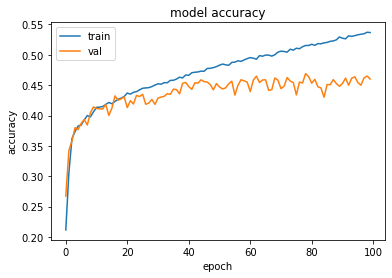

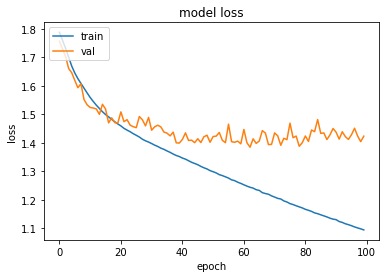

In [25]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# scores

In [26]:
from collections import Counter

correct = 0

#data_source = df
#data_source = df.loc[(df['source'] == "tec")]
data_source = df.loc[(df['source'] == "crowdflower")]

val_texts = data_source['text']
y_true = data_source.loc[:, (data_source.columns != 'text') & (data_source.columns != 'source')].values

print("Distribution of test-classes: ")
_, idx, count = np.unique(y_true.argmax(axis=1), return_counts=1, return_index=1)
print({tuple(i):j for i,j in zip(y_true[idx],count)})

y_pred = []
# convert one-hot to sequence array
y_true = y_true.argmax(axis=1)

predictions = nn_predict_many(val_texts)
print(predictions)
for i in range(0,len(val_texts)):
    y_pred.append(predictions[i])
    if predictions[i] == y_true[i]:
        correct += 1
y_pred = np.array(y_pred)

Distribution of test-classes: 
{(1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 9220, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 1421, (0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 5123, (0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 179, (0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 8430, (0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 2177}
[0 5 5 ... 0 2 4]


In [27]:
# convert to strings
emotions = ['joy', 'anger', 'sadness', 'disgust', 'fear', 'surprise']
y_true = [emotions[x] for x in y_true]
y_pred = [emotions[x] for x in y_pred]

In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print("Accuracy:")
print(correct/len(val_texts))
print("F1 score micro")
print(f1_score(y_true, y_pred, average="micro"))
print("F1 score macro")
print(f1_score(y_true, y_pred, average="macro"))

# Look at class wise score
print(classification_report(y_true, y_pred, digits=3))

Accuracy:
0.2383804143126177
F1 score micro
0.2383804143126177
F1 score macro
0.19029027348879748
              precision    recall  f1-score   support

       anger      0.132     0.238     0.170      1421
     disgust      0.005     0.101     0.010       179
        fear      0.365     0.077     0.127      8430
         joy      0.490     0.284     0.360      9220
     sadness      0.267     0.413     0.324      5123
    surprise      0.104     0.269     0.150      2177

    accuracy                          0.238     26550
   macro avg      0.227     0.230     0.190     26550
weighted avg      0.353     0.238     0.249     26550



# confusion matrix

<ipython-input-29-f472bd7ae910>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+tags)
<ipython-input-29-f472bd7ae910>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+tags)


<Figure size 432x288 with 0 Axes>

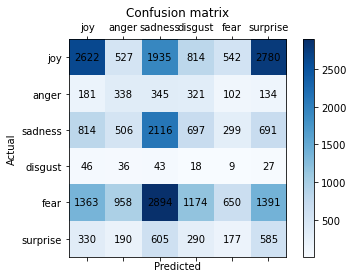

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

tags = ['joy', 'anger', 'sadness', 'disgust', 'fear', 'surprise']

cm = confusion_matrix(y_true,y_pred, labels = tags)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    im = ax.matshow(cm, cmap=cmap)
    fig.colorbar(im)
    plt.title(title)
    ax.set_xticklabels([""]+tags)
    ax.set_yticklabels([""]+tags)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, z, ha='center', va='center')
    plt.savefig(method + "_conf.png", bbox_inches='tight', transparent=False, pad_inches=0.1,  dpi=500)
    plt.show()

# Compute confusion matrix
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)